In [1]:
import datetime
from functools import partial
from typing import List, Callable
import yfinance as yf
import backtrader as bt
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span0=100):
        """
        Calculate the daily volatility of closing prices.

        Parameters:
        - close: A pandas Series of closing prices.
        - span0: The span for the EWM standard deviation.

        Returns:
        - A pandas Series of daily volatility estimates.
        """
        # Find the start of the previous day for each day
        prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        prev_day_start = prev_day_start[prev_day_start > 0]

        # Create a series with the start of the previous day for each day
        prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

        # Calculate daily returns
        daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

        # Calculate EWM standard deviation of daily returns
        daily_vol = daily_returns.ewm(span=span0).std()

        return daily_returns, daily_vol

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)
# Rename text_plit to text
rename = lambda original, new, df: df.rename(columns={original: new})

In [3]:
# @title load price data
address = "../raw/bitcoin_2015-01-01_2022-01-01.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
price_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit=None))
price_df = price_df.sort_index()
price_df = price_df[:"2021-02-01"]

In [4]:
# @title load text data
sentiment = True # @param {"type":"boolean","placeholder":"True"}
address = "../raw/impact_labeled.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["text", "impact_label", "date"]
text_df = pandas_data_loader(address, columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'), partial(rename, "text_split", "text"))
# text_df = text_df["2020-01-01":"2021-01-01"]

In [5]:
# Calculate daily volatility using TripleBarrierLabeler
labeler = TripleBarrierLabeler()
labeler.fit(price_df)
price_df = labeler.transform()

In [6]:
price_df.head()

,open,high,low,close,volume,daily_returns,volatility,label,window_start,upper_barrier,lower_barrier
timestamp,,,,,,,,,,,
2015-01-01,320.193,320.435,314.003,314.136,1.305980e+07,NaN,NaN,1,True,NaN,NaN
2015-01-02,314.249,315.839,313.565,315.207,7.154870e+06,NaN,NaN,1,False,NaN,NaN
2015-01-03,315.032,315.150,284.234,284.234,1.612705e+07,-0.095188,NaN,1,False,NaN,NaN
2015-01-04,281.082,287.230,257.612,264.201,5.004449e+07,-0.161817,0.047114,1,False,NaN,NaN
2015-01-05,264.195,278.341,264.195,274.570,4.961979e+07,-0.034000,0.068406,1,False,NaN,NaN


In [7]:
means = text_df["impact_label"].groupby(text_df.index).mean()

In [8]:
def generate_signal_and_size(row, bearish_threshold=0.8, bullish_threshold=1.2):
    if row < bearish_threshold:
        return -1, abs(row - bearish_threshold)  # Bearish signal and position size
    elif row > bullish_threshold:
        return 1, abs(row - bullish_threshold)  # Bullish signal and position size
    else:
        return 0, 0  # Neutral signal and position size

In [9]:
means = pd.DataFrame(means)

In [10]:
means["signal"], means["position_size"] = zip(*means["impact_label"].apply(generate_signal_and_size))

In [11]:
means["signal"].value_counts()

signal
 0    929
 1    698
-1    477
Name: count, dtype: int64

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
position_sizes = means[['position_size']]  # Ensure it's a DataFrame
means['position_size'] = scaler.fit_transform(position_sizes)

In [13]:
class PandasDataWithSignalVolatilityAndSize(bt.feeds.PandasData):
    lines = ('signal', 'volatility', 'position_size')
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
        ('signal', -1),
        ('volatility', -1),
        ('position_size', -1),
    )

In [14]:
price_df = price_df.merge(means[['signal', 'position_size']], left_index=True, right_index=True, how='left')

In [15]:
price_df.volatility.fillna(0, inplace=True)
price_df.signal.fillna(0, inplace=True)
price_df.position_size.fillna(0, inplace=True)

In [16]:
price_df.signal.value_counts()

signal
 0.0    1049
 1.0     698
-1.0     477
Name: count, dtype: int64

In [109]:
feeds = [
    PandasDataWithSignalVolatilityAndSize(dataname=price_df["2015-01-01":"2016-01-01"]),
    PandasDataWithSignalVolatilityAndSize(dataname=price_df["2016-01-01":"2017-01-01"]),
    PandasDataWithSignalVolatilityAndSize(dataname=price_df["2017-01-01":"2018-01-01"]),
    PandasDataWithSignalVolatilityAndSize(dataname=price_df["2018-01-01":"2019-01-01"]),
    PandasDataWithSignalVolatilityAndSize(dataname=price_df["2019-01-01":"2020-01-01"]),
    PandasDataWithSignalVolatilityAndSize(dataname=price_df["2020-01-01":"2021-02-15"])
]

Final Model Strategy Code :


In [110]:
class ModelStrategy(bt.Strategy):
    params = (
        ('vertical_barrier', 30),  # Number of bars after which to close the position
        ('max_days_open', 30),  # Maximum number of days a position can be open
        ('base_position_size', 1),  # Base position size as a percentage of balance
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.signal = self.datas[0].signal
        self.volatility = self.datas[0].volatility
        self.position_size = self.datas[0].position_size
        self.order = None  # Keep track of pending orders
        self.entry_price = None  # Track the entry price of a position
        self.tp_price = None  # Take Profit price
        self.sl_price = None  # Stop Loss price
        self.entry_bar = None  # Track the bar at which the position was opened
        self.days_open = 0  # Track the number of days the position has been open

    def log(self, txt, dt=None):
        """ Logging function for this strategy """
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')

    def next(self):
        current_signal = self.signal[0]  # Access the current value of the signal
        current_volatility = self.volatility[0]  # Access the current value of the volatility
        current_position_size = self.position_size[0]  # Access the current value of the position size

        if self.order:  # If there is a pending order, do nothing
            return

        if self.position.size == 0:
            self.days_open = 0  # Reset the days open counter when opening a new position
            cash = self.broker.get_cash()  # Get the current cash balance
            position_value = cash * current_position_size  # Calculate the position value
            units = position_value / self.dataclose[0]  # Calculate the number of units to buy/sell

            if current_signal > 0:  # If the signal is BUY
                self.entry_price = self.dataclose[0]
                self.tp_price = self.entry_price + (self.entry_price * current_volatility)
                self.sl_price = self.entry_price - (self.entry_price * current_volatility)
                self.entry_bar = len(self)
                self.buy(size=units)  # Enter long with calculated units
                self.log(f'BUY: {units:.2f} units at {self.dataclose[0]:.2f}, for {units * self.dataclose[0]:.2f}$, TP: {self.tp_price:.2f}, SL: {self.sl_price:.2f}')
                self.log(f'Portfolio Value: {self.broker.getvalue():.2f}')

            elif current_signal < 0:  # If the signal is SELL
                self.entry_price = self.dataclose[0]
                self.tp_price = self.entry_price - (self.entry_price * current_volatility)
                self.sl_price = self.entry_price + (self.entry_price * current_volatility)
                self.entry_bar = len(self)
                self.sell(size=units)  # Enter short with calculated units
                self.log(f'SELL: {units:.2f} units at {self.dataclose[0]:.2f}, for {units * self.dataclose[0]:.2f}$, TP: {self.tp_price:.2f}, SL: {self.sl_price:.2f}')
                self.log(f'Portfolio Value: {self.broker.getvalue():.2f}')

            elif current_signal == 0:  # HOLD does nothing
                self.log('HOLDING position')
                self.log(f'Portfolio Value: {self.broker.getvalue():.2f}')

        elif self.position.size != 0:  # If we have an open position
            self.days_open += 1  # Increment the days open counter
            if self.dataclose[0] >= self.tp_price:  # Check for Take Profit
                self.close()
                self.log(f'Take Profit hit at {self.dataclose[0]:.2f} for position')
            elif self.dataclose[0] <= self.sl_price:  # Check for Stop Loss
                self.close()
                self.log(f'Stop Loss hit at {self.dataclose[0]:.2f} for position')
            elif self.days_open >= self.params.max_days_open:  # Check if the position has been open for too long
                self.log(f'Closing position due to lack of volatility after {self.days_open} days')
                self.close()
            elif self.entry_bar is not None:
                if len(self) - self.entry_bar >= self.params.vertical_barrier:
                    self.log(f'Vertical Barrier hit at {self.dataclose[0]:.2f} after {self.params.vertical_barrier} bars for position')
                    self.close()  # Close the position
                    self.entry_bar = None  # Reset the entry bar

In [ ]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(1000.0)
cerebro.adddata(feed_2015)
cerebro.addstrategy(ModelStrategy)
cerebro.broker.setcommission(commission=0.005)
# cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
teststrat = cerebro.run()

<IPython.core.display.Javascript object>

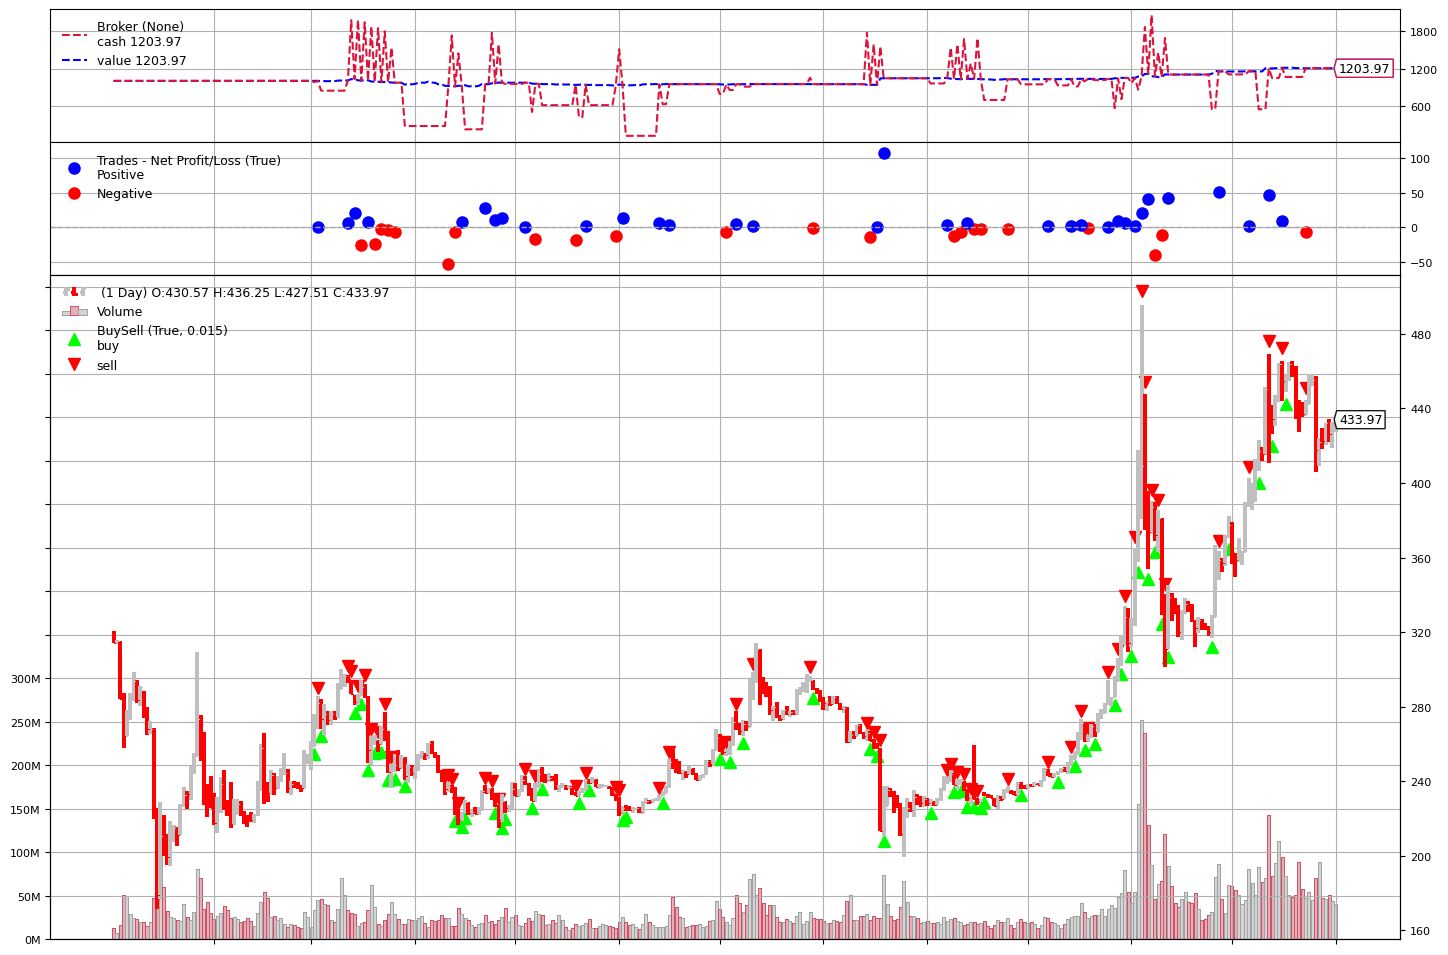

In [83]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [15, 10]  # Width, Height in inches

# Set the default font size
plt.rcParams.update({'font.size': 8})

# Set the default line style
plt.rcParams['lines.linestyle'] = '--'

# Set the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# Use the 'ggplot' style
plt.style.use('tableau-colorblind10')

plot = cerebro.plot(figsize=(70, 50), style='tableau-colorblind10')
plt.savefig("strategy.png")
plot[0][0]

In [112]:
def print_analysis(analyzer):
    total_return = final_balance / initial_balance

    print(f"Final Portfolio Value: {final_balance:.2f}")
    print(f"Total Return: {total_return:.2f}")

    # Returns
    returns = analyzer.analyzers.returns.get_analysis()
    print(f"Annualized Return: {returns['rnorm']:.2f}")
    print(f"Daily Return: {returns['rnorm100']:.2f}")

    # Sharpe Ratio
    sharpe_ratio = analyzer.analyzers.sharpe_ratio.get_analysis()
    print(f"Sharpe Ratio: {sharpe_ratio['sharperatio']:.2f}")

    # Drawdown
    drawdown = analyzer.analyzers.drawdown.get_analysis()
    print(f"Max Drawdown: {drawdown['max']['drawdown']:.2f}%")
    print(f"Max Drawdown Duration: {drawdown['max']['len']} days")

    # Trade Analyzer
    trade_analyzer = analyzer.analyzers.trade_analyzer.get_analysis()
    print("Trade Analyzer:")
    print(f"  Total Trades: {trade_analyzer}")
    # print(f"  Winning Trades: {trade_analyzer.won.total}")
    # print(f"  Losing Trades: {trade_analyzer.lost.total}")

    # Transactions
    # transactions = analyzer.analyzers.transactions.get_analysis()
    # print("Transactions:")
    # for date, trans in transactions.items():
    #     print(f"  {date}: {trans}")

    # Positions
    # positions = analyzer.analyzers.positions.get_analysis()
    # print("Positions:")
    # for date, pos in positions.items():
    #     print(f"  {date}: {pos}")

    # Time Return
    # time_return = analyzer.analyzers.time_return.get_analysis()
    # print(f"Time Return: {time_return}")

    # Annual Return
    annual_return = analyzer.analyzers.annual_return.get_analysis()
    print("Annual Returns:")
    for year, ret in annual_return.items():
        print(f"  {year}: {ret:.2f}%")

# Print the analysis for the first strategy
print_analysis(analyzers[5][0])

Final Portfolio Value: 10000.00
Total Return: 10.00
Annualized Return: 0.84
Daily Return: 84.02
Sharpe Ratio: 1.03
Max Drawdown: 16.08%
Max Drawdown Duration: 119 days
Trade Analyzer:
  Total Trades: AutoOrderedDict([('total', AutoOrderedDict([('total', 65), ('open', 1), ('closed', 64)])), ('streak', AutoOrderedDict([('won', AutoOrderedDict([('current', 0), ('longest', 10)])), ('lost', AutoOrderedDict([('current', 1), ('longest', 6)]))])), ('pnl', AutoOrderedDict([('gross', AutoOrderedDict([('total', 2401.513835253165), ('average', 37.5236536758307)])), ('net', AutoOrderedDict([('total', 1620.114011483298), ('average', 25.314281429426533)]))])), ('won', AutoOrderedDict([('total', 42), ('pnl', AutoOrderedDict([('total', 2811.385129224916), ('average', 66.93774117202182), ('max', 407.9484856534995)]))])), ('lost', AutoOrderedDict([('total', 22), ('pnl', AutoOrderedDict([('total', -1191.2711177416181), ('average', -54.14868717007355), ('max', -241.1149023556332)]))])), ('long', AutoOrdere

In [93]:
teststrat[0].analyzers.trade_analyzer.get_analysis()["total"]

AutoOrderedDict([('total', 55), ('open', 0), ('closed', 55)])

### buy and hold

In [56]:
class BuyAndHoldStrategy(bt.Strategy):
    def __init__(self):
        self.buy_order = None

    def next(self):
        if self.buy_order is None:
            cash = self.broker.get_cash()
            close = self.datas[0].close[0]
            units = cash // close
            self.buy_order = self.buy(size=units)
            self.log(f'BUY: {units:.2f} units at {close:.2f}')

    def stop(self):
        # Sell all remaining holdings at the end of the period
        if self.position.size > 0:
            self.sell(size=self.position.size)
            self.log(f'SOLD all holdings at {self.data.close[0]:.2f} at end of period')

    def log(self, txt, dt=None):
        """ Logging function for this strategy """
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')


In [66]:
# Set up the backtest
cerebro = bt.Cerebro()
# Get the final portfolio value
final_balance = cerebro.broker.getvalue()
initial_balance = 1000.0  # Initial balance
cerebro.broker.setcash(initial_balance)  # Set initial cash
cerebro.addstrategy(BuyAndHoldStrategy)
cerebro.adddata(feed_2015)
# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
# cerebro.addanalyzer(bt.analyzers.Positions, _name='positions')
# Run the backtest
teststrat = cerebro.run()
plot = cerebro.plot()

2015-01-01 - BUY: 3.00 units at 314.14
2016-01-01 - SOLD all holdings at 433.97 at end of period


<IPython.core.display.Javascript object>

In [73]:
def print_analysis(analyzer):
    total_return = final_balance / initial_balance

    print(f"Final Portfolio Value: {final_balance:.2f}")
    print(f"Total Return: {total_return:.2f}")

    # Returns
    returns = analyzer.analyzers.returns.get_analysis()
    print(f"Annualized Return: {returns['rnorm']:.2f}")
    print(f"Daily Return: {returns['rnorm100']:.2f}")

    # Sharpe Ratio
    sharpe_ratio = analyzer.analyzers.sharpe_ratio.get_analysis()
    print(f"Sharpe Ratio: {sharpe_ratio['sharperatio']:.2f}")

    # Drawdown
    drawdown = analyzer.analyzers.drawdown.get_analysis()
    print(f"Max Drawdown: {drawdown['max']['drawdown']:.2f}%")
    print(f"Max Drawdown Duration: {drawdown['max']['len']} days")

    # Trade Analyzer
    trade_analyzer = analyzer.analyzers.trade_analyzer.get_analysis()
    print("Trade Analyzer:")
    print(f"  Total Trades: {trade_analyzer}")
    # print(f"  Winning Trades: {trade_analyzer.won.total}")
    # print(f"  Losing Trades: {trade_analyzer.lost.total}")

    # Transactions
    # transactions = analyzer.analyzers.transactions.get_analysis()
    # print("Transactions:")
    # for date, trans in transactions.items():
    #     print(f"  {date}: {trans}")

    # Positions
    # positions = analyzer.analyzers.positions.get_analysis()
    # print("Positions:")
    # for date, pos in positions.items():
    #     print(f"  {date}: {pos}")

    # Time Return
    # time_return = analyzer.analyzers.time_return.get_analysis()
    # print(f"Time Return: {time_return}")

    # Annual Return
    annual_return = analyzer.analyzers.annual_return.get_analysis()
    print("Annual Returns:")
    for year, ret in annual_return.items():
        print(f"  {year}: {ret:.2f}%")

# Print the analysis for the first strategy
print_analysis(teststrat[0])

Final Portfolio Value: 10000.00
Total Return: 10.00
Annualized Return: 0.24
Daily Return: 23.53
Sharpe Ratio: 0.99
Max Drawdown: 40.81%
Max Drawdown Duration: 300 days
Trade Analyzer:
  Total Trades: AutoOrderedDict([('total', AutoOrderedDict([('total', 1), ('open', 1)]))])
Annual Returns:
  2015: 0.35%
  2016: 0.01%


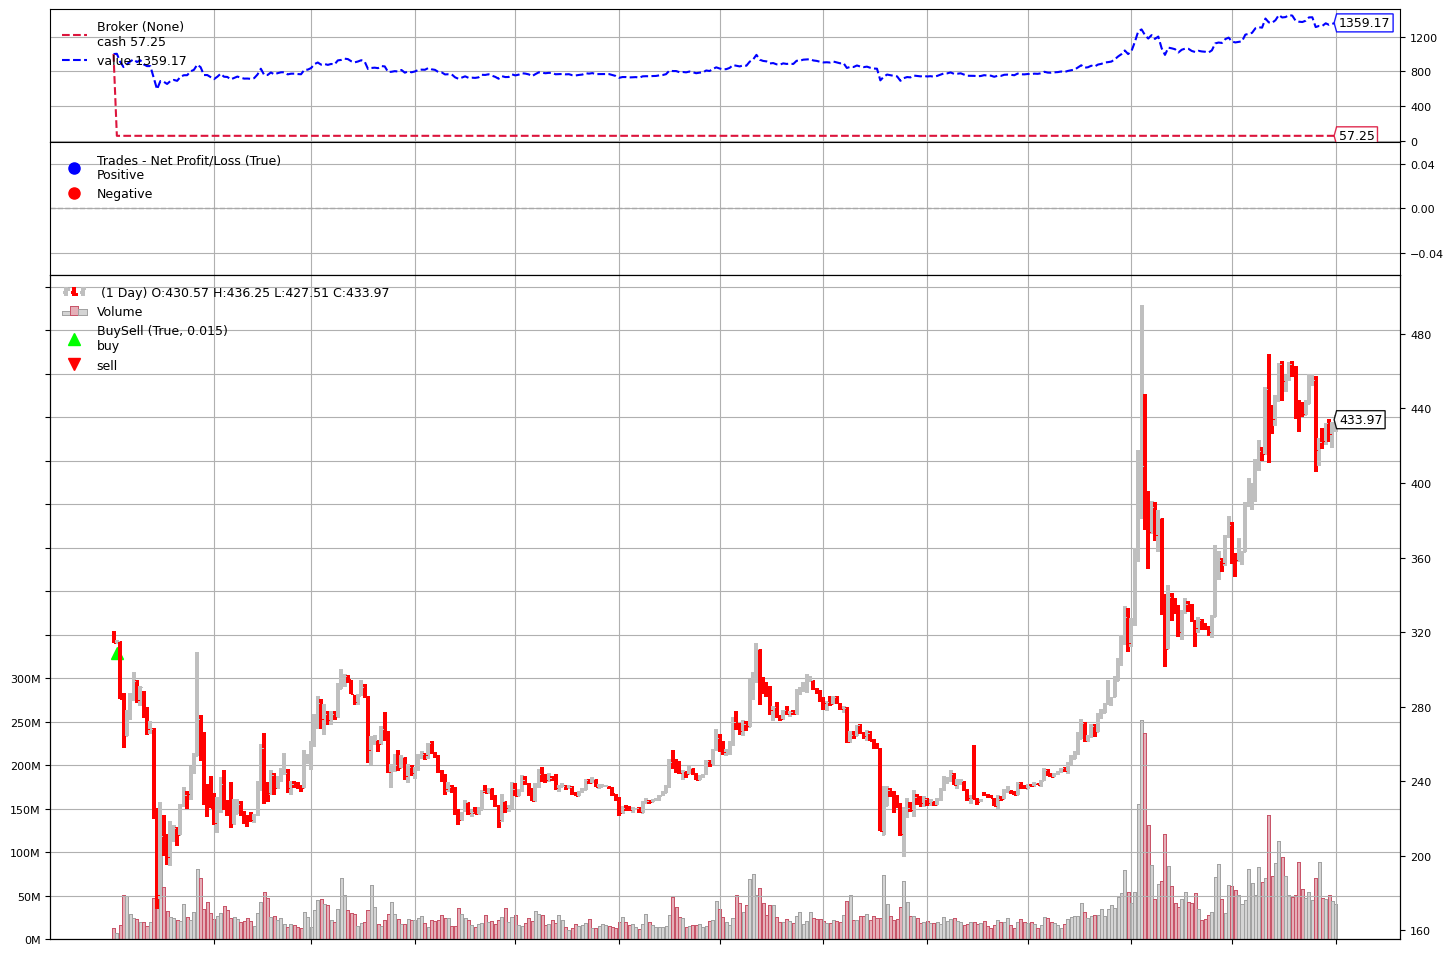

In [63]:
plot[0][0]

Backtrader initial method for SL & TP

In [14]:
# class ModelStrategy(bt.Strategy):
#     params = (
#         ('tp_multiplier', 1.05),  # Take Profit at 5% above the entry price
#         ('sl_multiplier', 0.95),  # Stop Loss at 5% below the entry price
#     )
#     def __init__(self):
#         self.dataclose = self.datas[0].close
#         self.signal = self.datas[0].signal
#         self.order = None  # Keep track of pending orders
#         self.entry_price = None  # Track the entry price of a position
#         self.tp_price = None  # Take Profit price
#         self.sl_price = None  # Stop Loss price

#     def next(self):
#         current_signal = self.signal[0]  # Access the current value of the signal
#         print(f"Signal: {current_signal}, Close: {self.dataclose[0]}")  # Print signal value

#         if self.order:  # If there is a pending order, do nothing
#           return

#         # if self.position.size > 0:  # If we have an open position
#         #   if self.dataclose[0] >= self.tp_price:  # Check for Take Profit
#         #       self.close()
#         #       print(f"Take Profit hit at {self.dataclose[0]} for long position")
#         #   elif self.dataclose[0] <= self.sl_price:  # Check for Stop Loss
#         #       self.close()
#         #       print(f"Stop Loss hit at {self.dataclose[0]} for long position")

#         # if self.position.size < 0:  # If we have an open position
#         #   if self.dataclose[0] <= self.tp_price:  # Check for Take Profit
#         #       self.close()
#         #       print(f"Take Profit hit at {self.dataclose[0]} for short position")
#         #   elif self.dataclose[0] >= self.sl_price:  # Check for Stop Loss
#         #       self.close()
#         #       print(f"Stop Loss hit at {self.dataclose[0]} for short position")

#         # If the signal is BUY
#         if current_signal == 1:
#             if self.position.size < 0:  # If we're short, close the short position
#                 self.close()
#                 print(f"Closing short position at {self.dataclose[0]} - BUY Signal")
#                 print('Portfolio Value: %.2f' % cerebro.broker.getvalue())
#             if self.position.size == 0:
#                 self.entry_price = self.dataclose[0]
#                 tp_price = self.entry_price * self.params.tp_multiplier
#                 sl_price = self.entry_price * self.params.sl_multiplier
#                 self.buy()  # Enter long or add to existing long position
#                 print(f"Buying at {self.dataclose[0]}, TP: {self.tp_price}, SL: {self.sl_price}")

#                 # Attach TP and SL orders
#                 self.sell(exectype=bt.Order.Stop, price=sl_price, parent=self.order)  # Stop Loss
#                 self.sell(exectype=bt.Order.Limit, price=tp_price, parent=self.order)  # Take Profit

#             else :
#                 print("Continue Holding - Buy signal")
#             print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

#         # If the signal is SELL
#         elif current_signal == -1:
#             if self.position.size > 0:  # If we're long, close the long position
#                 self.close()
#                 print(f"Closing long position at {self.dataclose[0]} - SELL Signal")
#                 print('Portfolio Value: %.2f' % cerebro.broker.getvalue())
#             if self.position.size == 0:
#                 self.entry_price = self.dataclose[0]
#                 tp_price = self.entry_price * (2 - self.params.sl_multiplier)  # Inverse logic for short
#                 sl_price = self.entry_price * (2 - self.params.tp_multiplier)
#                 self.sell()  # Enter short or add to existing short position
#                 print(f"Selling at {self.dataclose[0]}, TP: {self.tp_price}, SL: {self.sl_price}")

#                 # Attach TP and SL orders
#                 self.buy(exectype=bt.Order.Stop, price=sl_price, parent=self.order)  # Stop Loss
#                 self.buy(exectype=bt.Order.Limit, price=tp_price, parent=self.order)  # Take Profit


#             else :
#                 print("Continue Holding - Sell signal")
#             print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

#         # HOLD does nothing
#         elif current_signal == 0:
#             print("Holding position")
#             print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

#         print(f"Current position size: {self.position.size}")

#     def notify_order(self, order):
#       if order.status in [order.Completed]:
#           if order.exectype == bt.Order.Limit and order == self.tp_order:
#               print(f"Take Profit executed at {order.executed.price}")
#           elif order.exectype == bt.Order.Stop and order == self.sl_order:
#               print(f"Stop Loss executed at {order.executed.price}")

#       # Reset the order variables once the parent order is completed
#       if order.status in [order.Completed, order.Canceled, order.Margin]:
#           self.order = None
#           self.tp_order = None
#           self.sl_order = None

Backtrader Initial SL & TP Method + Backtrader initial notify method

In [15]:
# class ModelStrategy(bt.Strategy):
#     params = (
#         ('tp_multiplier', 1.05),  # Take Profit at 5% above the entry price
#         ('sl_multiplier', 0.95),  # Stop Loss at 5% below the entry price
#     )
#     def __init__(self):
#         self.dataclose = self.datas[0].close
#         self.signal = self.datas[0].signal
#         self.order = None  # Keep track of pending orders
#         self.entry_price = None  # Track the entry price of a position
#         self.tp_price = None  # Take Profit price
#         self.sl_price = None  # Stop Loss price

#     def next(self):
#         current_signal = self.signal[0]  # Access the current value of the signal
#         print(f"Signal: {current_signal}, Close: {self.dataclose[0]}")  # Print signal value

#         if self.order:  # If there is a pending order, do nothing
#           return

#         # if self.position.size > 0:  # If we have an open position
#         #   if self.dataclose[0] >= self.tp_price:  # Check for Take Profit
#         #       self.close()
#         #       print(f"Take Profit hit at {self.dataclose[0]} for long position")
#         #   elif self.dataclose[0] <= self.sl_price:  # Check for Stop Loss
#         #       self.close()
#         #       print(f"Stop Loss hit at {self.dataclose[0]} for long position")

#         # if self.position.size < 0:  # If we have an open position
#         #   if self.dataclose[0] <= self.tp_price:  # Check for Take Profit
#         #       self.close()
#         #       print(f"Take Profit hit at {self.dataclose[0]} for short position")
#         #   elif self.dataclose[0] >= self.sl_price:  # Check for Stop Loss
#         #       self.close()
#         #       print(f"Stop Loss hit at {self.dataclose[0]} for short position")

#         # If the signal is BUY
#         if current_signal == 1:
#             if self.position.size < 0:  # If we're short, close the short position
#                 self.close()
#                 # print(f"Closing short position at {self.dataclose[0]} - BUY Signal")
#                 print('Portfolio Value: %.2f' % cerebro.broker.getvalue())
#             if self.position.size == 0:
#                 self.entry_price = self.dataclose[0]
#                 tp_price = self.entry_price * self.params.tp_multiplier
#                 sl_price = self.entry_price * self.params.sl_multiplier
#                 self.buy()  # Enter long or add to existing long position
#                 # print(f"Buying at {self.dataclose[0]}, TP: {self.tp_price}, SL: {self.sl_price}")

#                 # Attach TP and SL orders
#                 self.sell(exectype=bt.Order.Stop, price=sl_price, parent=self.order)  # Stop Loss
#                 self.sell(exectype=bt.Order.Limit, price=tp_price, parent=self.order)  # Take Profit

#             # else :
#                 # print("Continue Holding - Buy signal")
#             # print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

#         # If the signal is SELL
#         elif current_signal == -1:
#             if self.position.size > 0:  # If we're long, close the long position
#                 self.close()
#                 # print(f"Closing long position at {self.dataclose[0]} - SELL Signal")
#                 print('Portfolio Value: %.2f' % cerebro.broker.getvalue())
#             if self.position.size == 0:
#                 self.entry_price = self.dataclose[0]
#                 tp_price = self.entry_price * (2 - self.params.sl_multiplier)  # Inverse logic for short
#                 sl_price = self.entry_price * (2 - self.params.tp_multiplier)
#                 self.sell()  # Enter short or add to existing short position
#                 # print(f"Selling at {self.dataclose[0]}, TP: {self.tp_price}, SL: {self.sl_price}")

#                 # Attach TP and SL orders
#                 self.buy(exectype=bt.Order.Stop, price=sl_price, parent=self.order)  # Stop Loss
#                 self.buy(exectype=bt.Order.Limit, price=tp_price, parent=self.order)  # Take Profit


#             # else :
#                 # print("Continue Holding - Sell signal")
#             # print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

#         # HOLD does nothing
#         elif current_signal == 0:
#             # print("Holding position")
#             print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

#         print(f"Current position size: {self.position.size}")


#     def notify_order(self, order):
#         if order.status in [order.Completed]:
#             if order.isbuy():
#                 print(f"Buy Order Completed: {order.info['name']} at price {order.executed.price}")
#             elif order.issell():
#                 print(f"Sell Order Completed: {order.info['name']} at price {order.executed.price}")

#             if order.exectype == bt.Order.Limit and order == self.tp_order:
#                 print(f"Take Profit executed at {order.executed.price}")
#             elif order.exectype == bt.Order.Stop and order == self.sl_order:
#                 print(f"Stop Loss executed at {order.executed.price}")

#         # Reset the order variables once the parent order is completed or canceled
#         if order.status in [order.Completed, order.Canceled, order.Margin]:
#             self.order = None
#             self.tp_order = None
#             self.sl_order = None

In [28]:
price_df['signal'].value_counts()

signal
 1    230
-1    107
 0     29
Name: count, dtype: int64

SMA Cross Strategy :

In [17]:
# # Create a subclass of Strategy to define the indicators and logic

# class SmaCross(bt.Strategy):
#     def __init__(self):
#         sma1 = bt.ind.SMA(period=50)  # fast moving average
#         sma2 = bt.ind.SMA(period=100)  # slow moving average
#         self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

#     def next(self):
#         if not self.position:  # not in the market
#             if self.crossover > 0:  # if fast crosses slow to the upside
#                 self.buy()  # enter long

#         elif self.crossover < 0:  # in the market & cross to the downside
#             self.close()  # close long position


Buy and Hold :

In [420]:
class BuyAndHold(bt.Strategy):
    def __init__(self):
      self.bought = False  # Track if we've already bought the asset
      self.dataclose = self.datas[0].close
    def next(self):
        if not self.position and not self.bought:  # not in the market
                self.buy()  # enter long
                print(f"Buying at {self.dataclose[0]}")
                self.bought = True  # mark that we have bought

Add which strategy you want to run :

In [421]:
cerebro.addstrategy(BuyAndHold)
# cerebro.addstrategy(SmaCross)
# cerebro.addstrategy(ModelStrategy)

1

In [422]:
cerebro.broker.setcommission(commission= 0.005)

In [423]:
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

In [424]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')

In [425]:
teststrat = cerebro.run()

Holding position
Portfolio Value: 10000.00
Buying at 314.136


TypeError: '>=' not supported between instances of 'float' and 'NoneType'

In [32]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 25087.12


In [45]:
plotinfo = dict(plot=True,
                subplot=True,
                plotname='',
                plotskip=False,
                plotabove=False,
                plotlinelabels=False,
                plotlinevalues=True,
                plotvaluetags=True,
                plotymargin=0.0,
                plotyhlines=[],
                plotyticks=[],
                plothlines=[],
                plotforce=False,
                plotmaster=None,
                plotylimited=True,
           )

In [48]:
plot = cerebro.plot()
print(type(plot[1][0]))
print(dir(plot[1][0]))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'matplotlib.figure.Figure'>
['_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_axes_internal', '_agg_filter', '_align_label_groups', '_alpha', '_animated', '_axobservers', '_axstack', '_button_pick_id', '_callbacks', '_canvas_callbacks', '_check_layout_engines_compat', '_clipon', '_clippath', '_cm_set', '_different_canvas', '_dpi', '_fully_clipped_to_axes', '_gci', '_get_dpi', '_get_draw_artists', '_get_renderer', '_gid', '_in_layout', '_internal_update', '_label', '_layout_engine', '_localaxes', '_mouse_key_ids', '_mouseover', '_norm_per_subplot_kw', '_normalize_grid_string', '_original_dpi', '_path_effects', '_picker',

Showing analysis metrics

In [34]:
teststrat[0].analyzers.sharpe_ratio.riskfreerate=0.02
# teststrat[0].analyzers.sharpe_ratio.timeframe=bt.TimeFrame.Days
teststrat[0].analyzers.sharpe_ratio.compression=1
# teststrat[0].analyzers.sharpe_ratio.convertrate=True
teststrat[0].analyzers.sharpe_ratio.factor=252
# teststrat[0].analyzers.sharpe_ratio.stddev_sample=False
# teststrat[0].analyzers.sharpe_ratio.fund=100


teststrat[0].analyzers.sharpe_ratio.annualize=True
aaa = teststrat[0]
aaa.analyzers.sharpe_ratio.get_analysis()

OrderedDict([('sharperatio', None)])

In [50]:
# Extract returns from the TimeReturn analyzer
returns = np.array(list(teststrat[0].analyzers.time_return.get_analysis().values()))

# Calculate mean and standard deviation of returns
mean_return = np.mean(returns)
stddev_return = np.std(returns, ddof=1)  # ddof=1 gives sample standard deviation

# Risk-free rate (adjust to match your scenario)
risk_free_rate = 0.02 / 365  # Daily risk-free rate (assuming 365 trading days in a year)

# Annualize mean return and standard deviation
mean_return_annualized = mean_return * 365
stddev_return_annualized = stddev_return * np.sqrt(365)

# Calculate Sharpe Ratio
sharpe_ratio_manual = (mean_return_annualized - risk_free_rate * 365) / stddev_return_annualized

print("Manual Sharpe Ratio:", sharpe_ratio_manual)


Manual Sharpe Ratio: -2.1554800044561615


In [51]:
teststrat[0].analyzers.drawdown.get_analysis()

AutoOrderedDict([('len', 283),
                 ('drawdown', 66.20656583588944),
                 ('moneydown', 8384.544055320255),
                 ('max',
                  AutoOrderedDict([('len', 283),
                                   ('drawdown', 68.97801757799132),
                                   ('moneydown', 8735.526755230221)]))])

In [37]:
teststrat[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', -0.8487081871428125),
             ('ravg', -0.0023188748282590506),
             ('rnorm', -0.44253550106804523),
             ('rnorm100', -44.253550106804525)])

In [38]:
teststrat[0].analyzers.time_return.get_analysis()

OrderedDict([(datetime.datetime(2020, 1, 1, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 2, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 3, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 4, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 5, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 6, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 7, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 8, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 9, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 10, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 11, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 12, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 13, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 14, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 15, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 16, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 17, 0, 0), 0.0),
             (datetime.

In [31]:
# teststrat[0].analyzers.annual_return.get_analysis()